In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
from scipy.ndimage import gaussian_filter
from scipy.signal import welch
from scipy.interpolate import interp1d

from config import *
from functions import *
from sim import *
from read_ramses import *


In [3]:
# choose simulation
sim_round = 9
sim_name = "fiducial"
sim_dir = move_to_sim_dir(sim_round, sim_name)
sim_latex = sim_name_to_latex[sim_name]
print()

dump = get_dump(aexp=0.1)
info = get_info(dump)

print("Dump: %d" % dump)
print("a_exp: %.3g" % info.aexp)
print("Maximum AMR level: %d" % info.amr_level_max)


Moving to directory '/home/za9132/scratch/romain/round9/fiducial'.

Dump: 52
a_exp: 0.1
Maximum AMR level: 13


In [4]:
data = SimpleNamespace(**np.load('starcat/data.npz'))
data.SFR = data.starmass_hist1d / np.diff(data.time1d)[0]

aexp_list = np.linspace(1e-3, 0.1, 1000)
time_list = np.array([aexp_to_proper_time(aexp_list[i]) for i in range(len(aexp_list))])
proper_time_to_aexp_interp = interp1d(time_list, aexp_list, fill_value='extrapolate')


### SFH

Text(0.5, 0, '$a_{\\rm exp}$')

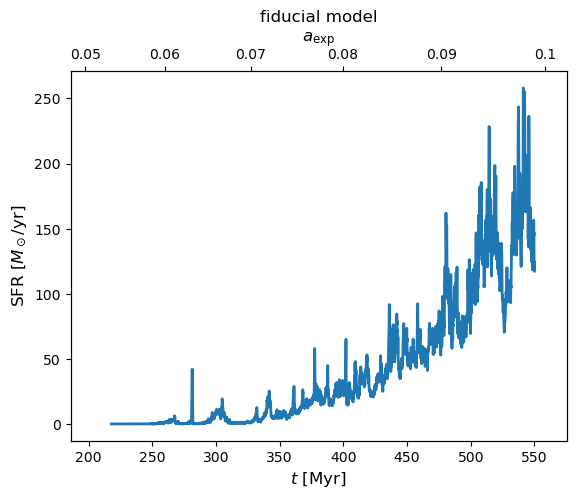

In [42]:
aexp_min = 0.048
aexp_max = 0.102
tick_aexp = np.arange(0.05, 0.1 + 0.01, 0.01)

ax1 = plt.gca()
cond = (data.SFR > 0)
ax1.plot(data.time1d[cond] / const.Myr, data.SFR[cond] / (const.M_sol / const.yr), lw=2, color='C0')

ax1.set_xlim(aexp_to_proper_time(aexp_min) / const.Myr, aexp_to_proper_time(aexp_max) / const.Myr)
ax1.set_ylabel(r"SFR [$M_\odot / {\rm yr}$]", fontsize=12)
ax1.set_xlabel(r"$t$ [Myr]", fontsize=12)
ax1.set_title(sim_latex)

ax2 = ax1.twiny()
ax2.set_xlim(aexp_to_proper_time(aexp_min) / const.Myr, aexp_to_proper_time(aexp_max) / const.Myr)
ax2.set_xticks([aexp_to_proper_time(tick) / const.Myr for tick in tick_aexp])
ax2.set_xticklabels(['%.2g' % tick for tick in tick_aexp])
ax2.set_xlabel(r'$a_{\rm exp}$', fontsize=12)


/tmp/ipykernel_3416092/2514003690.py:5: RuntimeWarning: divide by zero encountered in log10
  log_SFR = np.log10(SFR_ds)
/tmp/ipykernel_3416092/2514003690.py:8: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1 / freq / const.Myr, psd / const.Myr, lw=2)


Text(0.5, 1.0, 'fiducial model')

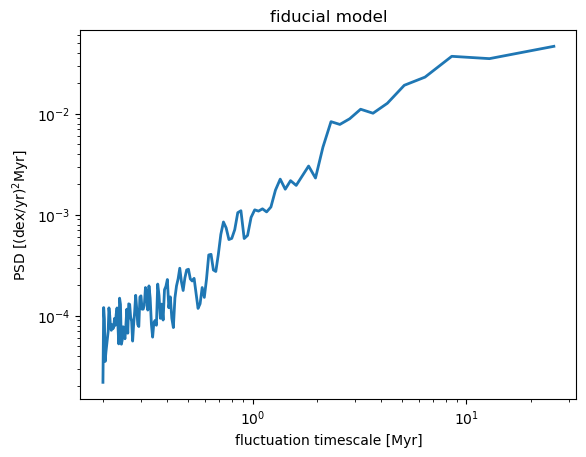

In [52]:
fac_ds = 1
time1d_ds, SFR_ds = downsample_hist(data.time1d, data.SFR, fac_ds=fac_ds)

cond = (time1d_ds > 350 * const.Myr) * (SFR_ds > 0)
log_SFR = np.log10(SFR_ds)
freq, psd = welch(log_SFR[cond], 1/(time1d_ds[1] - time1d_ds[0]), detrend='linear')

plt.plot(1 / freq / const.Myr, psd / const.Myr, lw=2)

plt.xlabel(r'fluctuation timescale [Myr]')
plt.ylabel(r'PSD [${\rm (dex/yr)^2 Myr}$]')
plt.xscale('log')
plt.yscale('log')
plt.title(sim_latex)

# save_fig("SFR-dxmin")


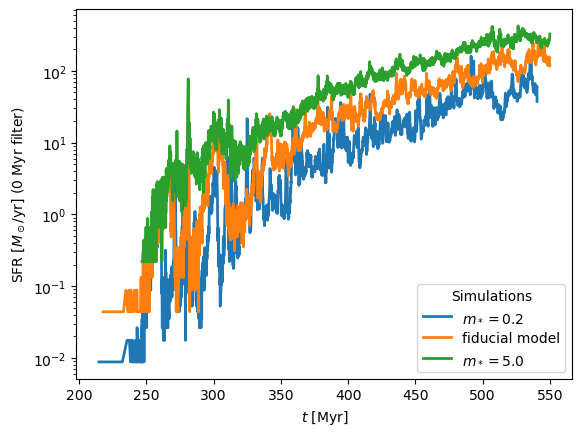

In [74]:
sim_list = [(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0")]
fsigma = 0 * const.Myr

for sim_round, sim_name in sim_list:
    move_to_sim_dir(sim_round, sim_name, do_print=False)
    sim_latex = sim_name_to_latex[sim_name]
    
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    data.SFR = data.starmass_hist1d / np.diff(data.time1d)[0]
    SFR_sm = gaussian_filter(data.SFR, sigma=(fsigma / np.diff(data.time1d)[0]))
    
    cond = (SFR_sm > 0)
    plt.plot(data.time1d[cond] / const.Myr, SFR_sm[cond] / (const.M_sol / const.yr), lw=2, label=sim_latex)

plt.ylabel(r"SFR [$M_\odot / {\rm yr}$] ($%.2g~{\rm Myr}$ filter)" % (fsigma / const.Myr))
plt.xlabel(r"$t$ [Myr]")
plt.legend(title='Simulations', fontsize=10)
plt.yscale('log')
    
#save_fig("SFR_comp2")
    

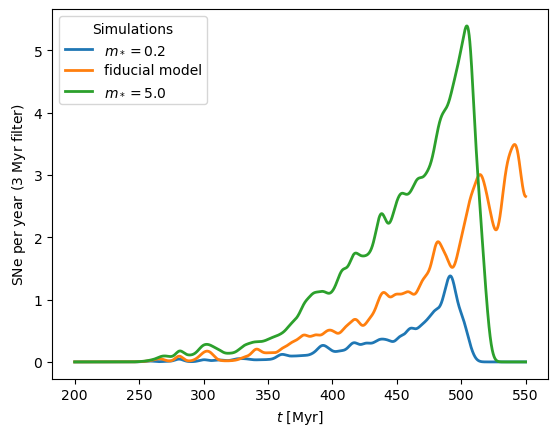

In [16]:
sim_list = [(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0")]
fsigma = 3 * const.Myr

for sim_round, sim_name in sim_list:
    move_to_sim_dir(sim_round, sim_name, do_print=False)
    sim_latex = sim_name_to_latex[sim_name]
    
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    SNeR = data.starnum_hist1d_death / np.diff(data.time1d)[0]
    SNeR_sm = gaussian_filter(SNeR, sigma=(fsigma / np.diff(data.time1d)[0]))
    
    cond = data.time1d > 200 * const.Myr
    plt.plot(data.time1d[cond] / const.Myr, SNeR_sm[cond] * const.yr, lw=2, label=sim_latex)

plt.ylabel(r"SNe per year ($%.2g~{\rm Myr}$ filter)" % (fsigma / const.Myr))
plt.xlabel(r"$t$ [Myr]")
plt.legend(title='Simulations', fontsize=10)
    

(0.1, 30.0)

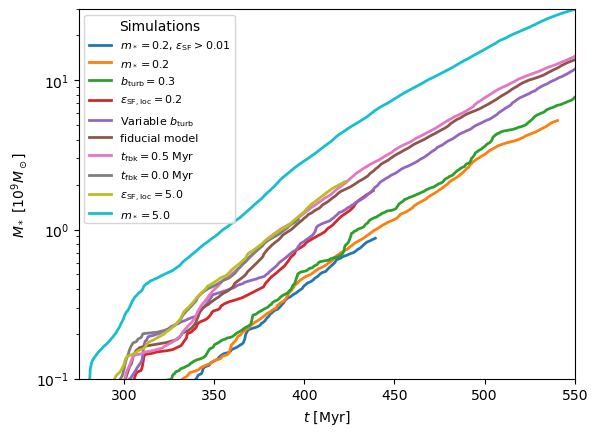

In [76]:
sim_list = [(9, "mstar0p2cut0p01"), (9, "mstar0p2"), (9, "bturb0p3"), (9, "eps0p2"), (9, "bturbfunc"), (9, "fiducial"), (9, "fastfeedback"), (9, "instantfeedback"), (9, "eps5p0"), (9, "mstar5p0")]

for sim_round, sim_name in sim_list:
    move_to_sim_dir(sim_round, sim_name, do_print=False)
    sim_latex = sim_name_to_latex[sim_name]
    
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    starmass = np.cumsum(data.starmass_hist1d)
    
    cond = data.starmass_hist1d > 0
    plt.plot(data.time1d[cond] / const.Myr, starmass[cond] / (1e9 * const.M_sol), label=sim_latex, lw=2)
    
plt.ylabel(r"$M_*$ [$10^9 M_\odot$]")
plt.xlabel(r"$t$ [Myr]")
plt.legend(title='Simulations', fontsize=8)

plt.yscale('log')
plt.xlim(275, 550)
plt.ylim(1e-1, 3e1)

#save_fig('starmass_megacomp')


/tmp/ipykernel_336311/3745200973.py:15: RuntimeWarning: divide by zero encountered in log10
  log_SFR = np.log10(SFR_ds)
/tmp/ipykernel_336311/3745200973.py:17: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1 / freq / const.Myr, psd / const.Myr, lw=2, label=sim_latex)


Saved figure as 'psd_comp-020720241316.png'


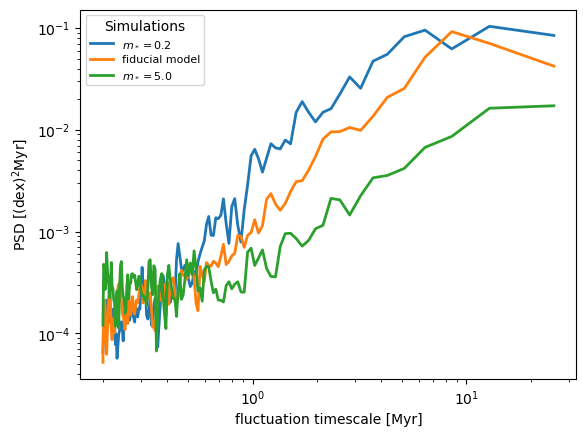

In [26]:
sim_list = [(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0")]
fac_ds = 1
time_min = 320 * const.Myr
time_max = 500 * const.Myr

for sim_round, sim_name in sim_list:
    move_to_sim_dir(sim_round, sim_name, do_print=False)
    sim_latex = sim_name_to_latex[sim_name]
    
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    data.SFR = data.starmass_hist1d / np.diff(data.time1d)[0]  
    time1d_ds, SFR_ds = downsample_hist(data.time1d, data.SFR, fac_ds=fac_ds)

    cond = (time1d_ds > time_min) * (time1d_ds < time_max)
    log_SFR = np.log10(SFR_ds)
    freq, psd = welch(log_SFR[cond], 1/(time1d_ds[1] - time1d_ds[0]), detrend='linear')
    plt.plot(1 / freq / const.Myr, psd / const.Myr, lw=2, label=sim_latex)

plt.xlabel(r'fluctuation timescale [Myr]')
plt.ylabel(r'PSD [${\rm (dex)^2 Myr}$]')
plt.xscale('log')
plt.yscale('log')
plt.legend(title='Simulations', fontsize=8)

save_fig('psd_comp')


### PDF

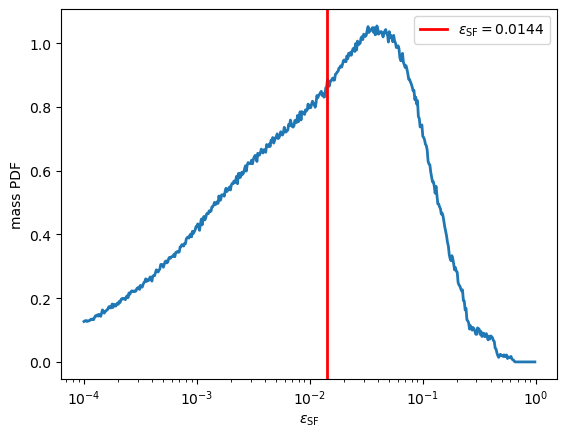

In [25]:
plt.plot(data.eps_sf1d, data.eps_sf_pdf1d, lw=2)
plt.xscale('log')
plt.xlabel(r'$\varepsilon_{\rm SF}$')
plt.ylabel('mass PDF')

eps_sf_median = median_weighted(data.eps_sf1d, data.eps_sf_pdf1d)
plt.axvline(x=eps_sf_median, lw=2, color='red')
add_custleg_to_ax([r'$\varepsilon_{\rm SF} = %.3g$' % eps_sf_median], ['red'])


Text(0, 0.5, 'mass PDF')

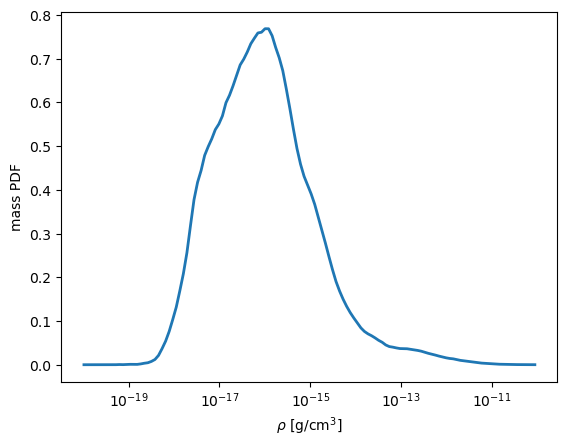

In [19]:
plt.plot(data.density_mff1d, data.density_mff_pdf1d, lw=2)
plt.xscale('log')
plt.xlabel(r'$\rho$ [${\rm g/cm^3}$]')
plt.ylabel('mass PDF')

# eps_sf_median = median_weighted(data.eps_sf1d, data.eps_sf_pdf1d)
# plt.axvline(x=eps_sf_median, lw=2, color='red')
# add_custleg_to_ax([r'$\varepsilon_{\rm SF} = %.3g$' % eps_sf_median], ['red'])


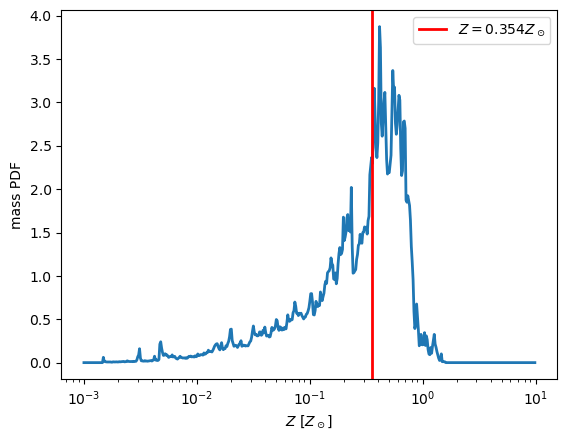

In [84]:
plt.plot(data.metallicity1d / const.Z_sol, data.metallicity_pdf1d, lw=2)
plt.xscale('log')
plt.xlabel(r'$Z$ [$Z_\odot$]')
plt.ylabel('mass PDF')

metallicity_median = median_weighted(data.metallicity1d, data.metallicity_pdf1d)
plt.axvline(x=metallicity_median / const.Z_sol, lw=2, color='red')
add_custleg_to_ax([r'$Z = %.3g Z_\odot$' % (metallicity_median / const.Z_sol)], ['red'])


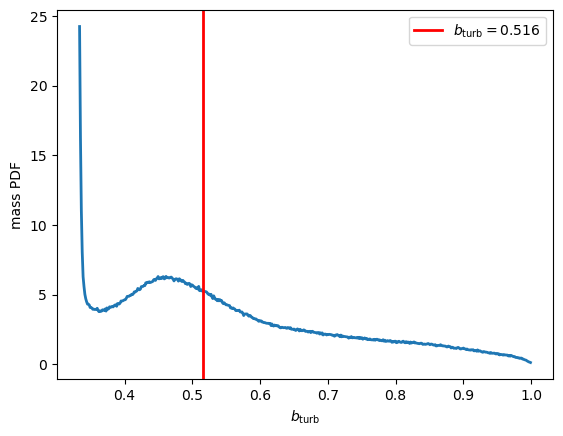

In [20]:
plt.plot(data.b_turb1d, data.b_turb_pdf1d, lw=2)
plt.xlabel(r'$b_{\rm turb}$')
plt.ylabel('mass PDF')

b_turb_median = median_weighted(data.b_turb1d, data.b_turb_pdf1d)
plt.axvline(x=b_turb_median, lw=2, color='red')
add_custleg_to_ax([r'$b_{\rm turb} = %.3g$' % b_turb_median], ['red'])


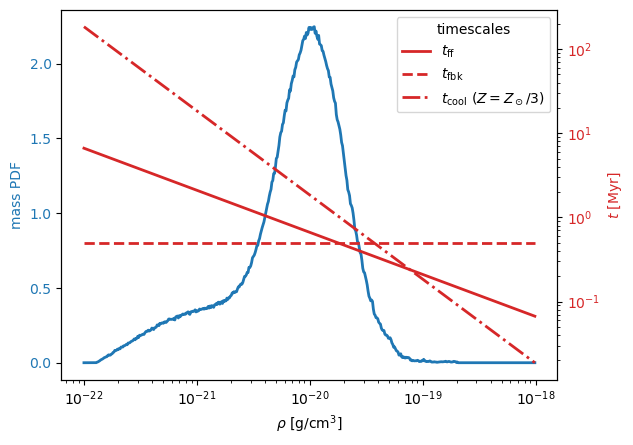

In [21]:
metallicity = 1/3 * const.Z_sol
temp = 10**4
C = 1

ax1 = plt.gca()

ax1.plot(data.density1d, data.density_pdf1d, lw=2)
#ax1.plot(data.density_mff1d, data.density_mff_pdf1d, lw=2)
ax1.set_xscale('log')
ax1.set_xlabel(r'$\rho$ [${\rm g/cm^3}$]')
ax1.set_ylabel('mass PDF', color='C0')
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = ax1.twinx()

n_H = const.X_cosmo * data.density1d / const.m_p
t_ff = np.sqrt(3 * np.pi / (32 * const.G * data.density1d))
t_fbk = np.full_like(data.density1d, 0.5 * const.Myr)
t_cool = 0.87 * const.Myr * (n_H / 10**3.5)**(-1) * (metallicity / const.Z_sol)**(-1) * (temp / 10**4) * np.exp(0.009 * (temp / 10**4)**(-1)) * C**(-1)

ax2.plot(data.density1d, t_ff / const.Myr, lw=2, color='C3', linestyle='-', label=r'$t_{\rm ff}$')
ax2.plot(data.density1d, t_fbk / const.Myr, lw=2, color='C3', linestyle='--', label=r'$t_{\rm fbk}$')
ax2.plot(data.density1d, t_cool / const.Myr, lw=2, color='C3', linestyle='-.', label=r'$t_{\rm cool}$ ($Z=Z_\odot/3$)')

ax2.set_yscale('log')
ax2.set_ylabel(r'$t$ [Myr]', color='C3')
ax2.tick_params(axis='y', labelcolor='C3')
ax2.legend(title='timescales', fontsize=10)

#save_fig('mff_dens_fastfbk')


Text(0, 0.5, 'mass PDF')

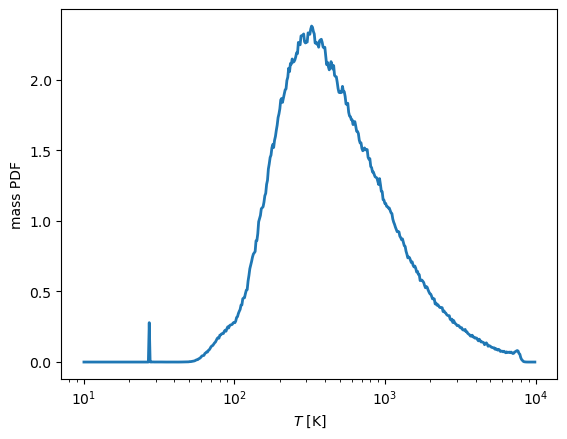

In [22]:
plt.plot(data.temp1d, data.temp_pdf1d, lw=2)
plt.xscale('log')
plt.xlabel(r'$T$ [${\rm K}$]')
plt.ylabel('mass PDF')


Text(0, 0.5, 'mass PDF')

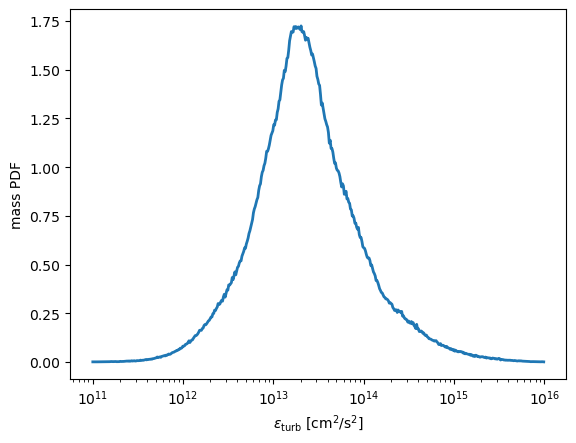

In [23]:
plt.plot(data.energy_turb1d, data.energy_turb_pdf1d, lw=2)
plt.xscale('log')
plt.xlabel(r'$\varepsilon_{\rm turb}$ [${\rm cm^2/s^2}$]')
plt.ylabel('mass PDF')


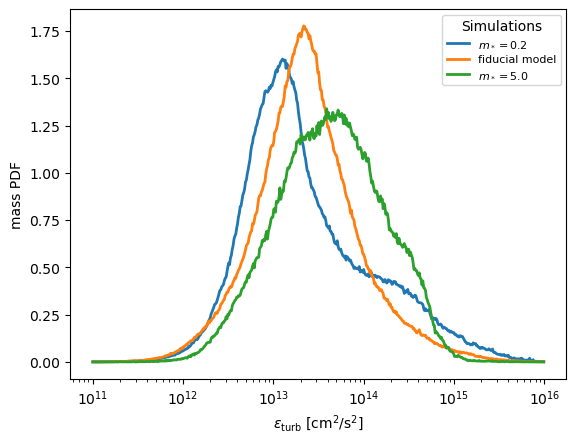

In [27]:
sim_list = [(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0")]

for i, (sim_round, sim_name) in enumerate(sim_list):
    move_to_sim_dir(sim_round, sim_name, do_print=False)
    sim_latex = sim_name_to_latex[sim_name]
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    plt.plot(data.energy_turb1d, data.energy_turb_pdf1d, lw=2, label=sim_latex)

plt.xscale('log')
plt.xlabel(r'$\varepsilon_{\rm turb}$ [${\rm cm^2/s^2}$]')
plt.ylabel('mass PDF')
plt.legend(title='Simulations', fontsize=8)

# save_fig('eturb-comp2')

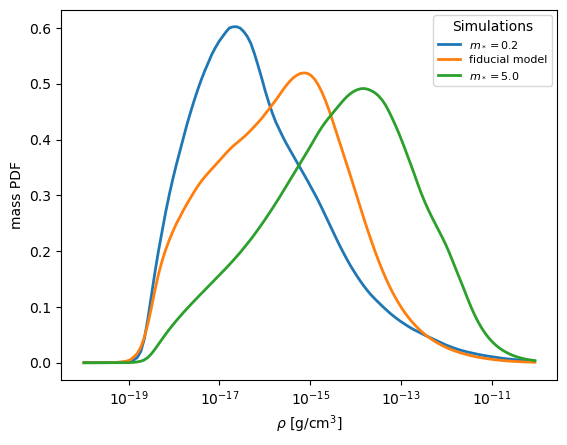

In [29]:
sim_list = [(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0")]

for i, (sim_round, sim_name) in enumerate(sim_list):
    move_to_sim_dir(sim_round, sim_name, do_print=False)
    sim_latex = sim_name_to_latex[sim_name]
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    plt.plot(data.density_mff1d, data.density_mff_pdf1d, lw=2, label=sim_latex)

plt.xscale('log')
plt.xlabel(r'$\rho$ [${\rm g/cm^3}$]')
plt.ylabel('mass PDF')
plt.legend(title='Simulations', fontsize=8)

#save_fig('rhomff-comp2')


Saved figure as 'rho-comp-020720241435.png'


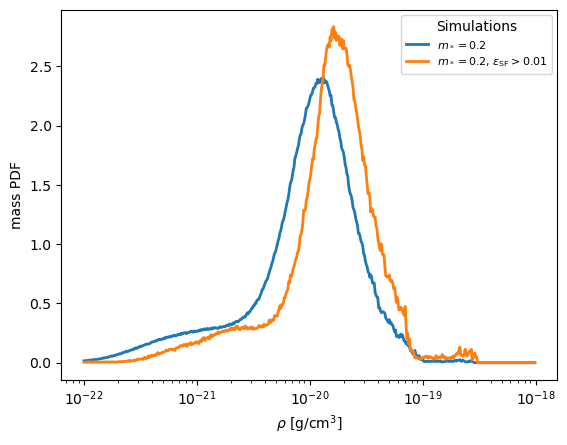

In [64]:
sim_list = [(9, "mstar0p2"), (9, "mstar0p2cut0p01")]

for i, (sim_round, sim_name) in enumerate(sim_list):
    move_to_sim_dir(sim_round, sim_name, do_print=False)
    sim_latex = sim_name_to_latex[sim_name]
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    plt.plot(data.density1d, data.density_pdf1d, lw=2, label=sim_latex)

plt.xscale('log')
plt.xlabel(r'$\rho$ [${\rm g/cm^3}$]')
plt.ylabel('mass PDF')
plt.legend(title='Simulations', fontsize=8)

# save_fig('rho-comp')


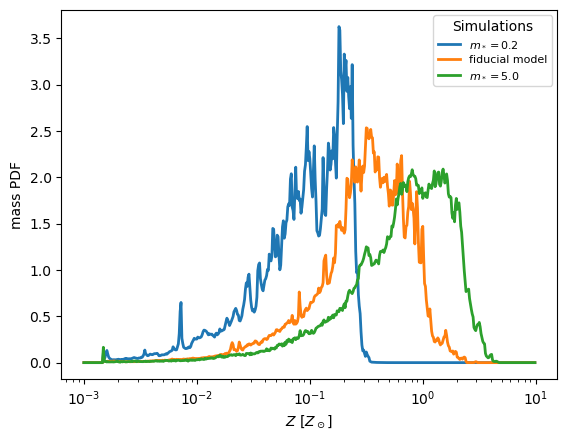

In [31]:
sim_list = [(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0")]

for i, (sim_round, sim_name) in enumerate(sim_list):
    move_to_sim_dir(sim_round, sim_name, do_print=False)
    sim_latex = sim_name_to_latex[sim_name]
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    plt.plot(data.metallicity1d / const.Z_sol, data.metallicity_pdf1d, lw=2, label=sim_latex)

plt.xscale('log')
plt.xlabel(r'$Z$ [$Z_\odot$]')
plt.ylabel('mass PDF')
plt.legend(title='Simulations', fontsize=8)

#save_fig('Z-comp')


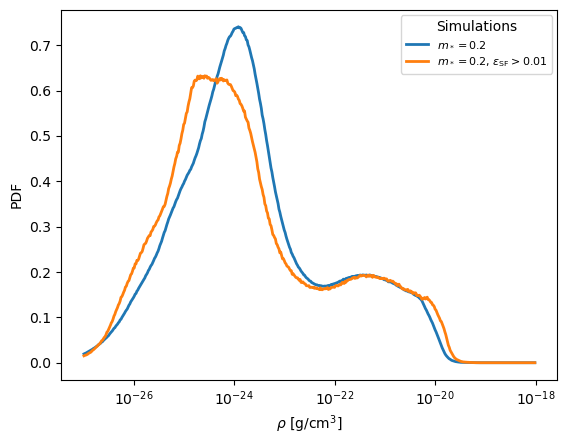

In [78]:
sim_list = [(9, "mstar0p2"), (9, "mstar0p2cut0p01")]

for i, (sim_round, sim_name) in enumerate(sim_list):
    move_to_sim_dir(sim_round, sim_name, do_print=False)
    sim_latex = sim_name_to_latex[sim_name]
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    plt.plot(data.density1d_death, data.density_pdf1d_death, lw=2, label=sim_latex)

plt.xscale('log')
plt.xlabel(r'$\rho$ [${\rm g/cm^3}$]')
plt.ylabel('PDF')
plt.legend(title='Simulations', fontsize=8)

#save_fig('rhoSNe-comp')


(0.0, 3.0)

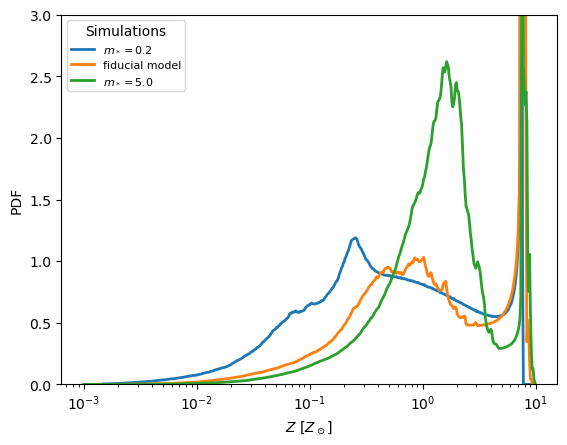

In [34]:
sim_list = [(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0")]

for i, (sim_round, sim_name) in enumerate(sim_list):
    move_to_sim_dir(sim_round, sim_name, do_print=False)
    sim_latex = sim_name_to_latex[sim_name]
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    plt.plot(data.metallicity1d_death / const.Z_sol, data.metallicity_pdf1d_death, lw=2, label=sim_latex)

plt.xscale('log')
plt.xlabel(r'$Z$ [$Z_\odot$]')
plt.ylabel('PDF')
plt.legend(title='Simulations', fontsize=8)

plt.ylim(0, 3)

#save_fig('Zdeath-comp')


1239.5433471235945
1580.2669917250487
444.57928059732683
200.56081869210038


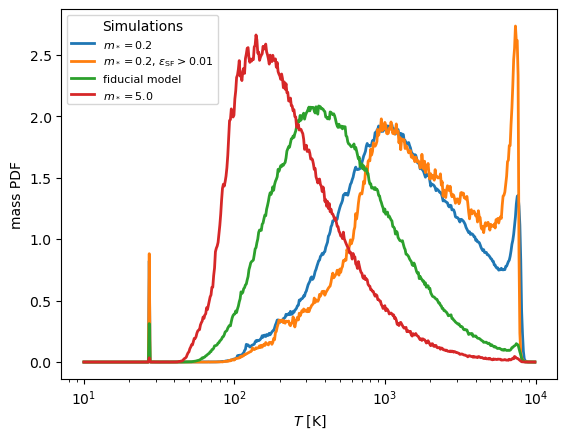

In [60]:
sim_list = [(9, "mstar0p2"), (9, "mstar0p2cut0p01"), (9, "fiducial"), (9, "mstar5p0")]

for i, (sim_round, sim_name) in enumerate(sim_list):
    move_to_sim_dir(sim_round, sim_name, do_print=False)
    sim_latex = sim_name_to_latex[sim_name]
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    plt.plot(data.temp1d, data.temp_pdf1d, lw=2, label=sim_latex)
    
    print(median_weighted(data.temp1d, data.temp_pdf1d))

plt.xscale('log')
plt.xlabel(r'$T$ [${\rm K}$]')
plt.ylabel('mass PDF')
plt.legend(title='Simulations', fontsize=8)

#save_fig('temp-comp2')


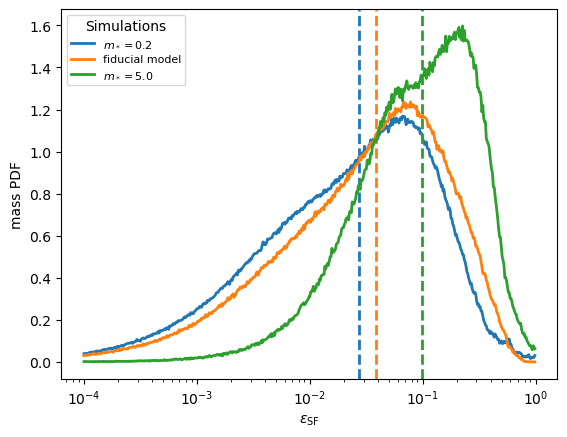

In [83]:
sim_list = [(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0")]

for i, (sim_round, sim_name) in enumerate(sim_list):
    move_to_sim_dir(sim_round, sim_name, do_print=False)
    sim_latex = sim_name_to_latex[sim_name]
    
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    
    plt.plot(data.eps_sf1d, data.eps_sf_pdf1d, lw=2, label=sim_latex)

    eps_sf_median = median_weighted(data.eps_sf1d, data.eps_sf_pdf1d)
    plt.axvline(x=eps_sf_median, lw=2, color='C%d' % i, linestyle='--')

plt.xscale('log')
plt.xlabel(r'$\varepsilon_{\rm SF}$')
plt.ylabel('mass PDF')
plt.legend(title='Simulations', fontsize=8)

# save_fig('epssf-comp-mstar')


### profiles

### phase space

Moving to directory '/home/za9132/scratch/romain/round9/mstar5p0'.


Text(0.5, 0, 'mass PDF')

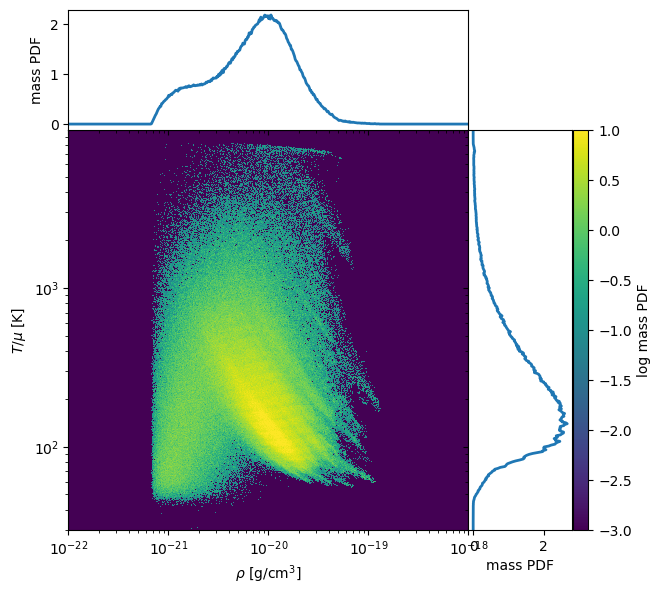

In [80]:
sim_dir = move_to_sim_dir(9, "mstar5p0")
data = SimpleNamespace(**np.load('starcat/data.npz'))

fig = plt.figure(figsize=(4, 4))
ax1 = fig.add_axes([0, 0, 1, 1])
im = ax1.pcolormesh(data.density2d, data.temp2d, np.log10(data.densitytemp_pdf2d + epsilon), vmin=-3, vmax=1)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1e-22, 1e-18)
ax1.set_ylim(30)

ax2 = fig.add_axes([0, 1, 1, 0.3], sharex=ax1)
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.plot(data.density1d, data.density_pdf1d, lw=2)

ax3 = fig.add_axes([1, 0, 0.3, 1], sharey=ax1)
plt.setp(ax3.get_yticklabels(), visible=False)
ax3.plot(data.temp_pdf1d, data.temp1d, lw=2)

add_cbar_to_ax(im, ax=ax3, size='15%', pad=0.01, label='log mass PDF')
ax1.set_xlabel(r'$\rho$ [${\rm g/cm^3}$]')
ax1.set_ylabel(r'$T / \mu$ [${\rm K}$]')
ax2.set_ylabel('mass PDF')
ax3.set_xlabel('mass PDF')


Moving to directory '/home/za9132/scratch/romain/round9/mstar0p2'.


Text(0.5, 0, 'mass PDF')

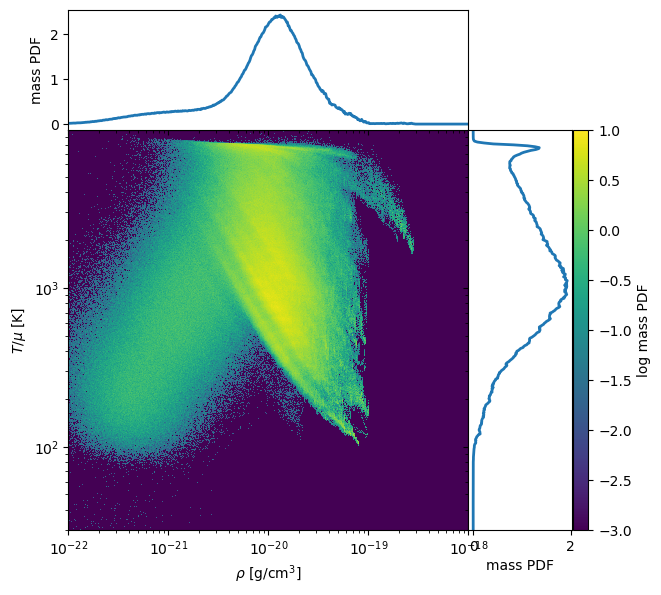

In [85]:
sim_dir = move_to_sim_dir(9, "mstar0p2")
data = SimpleNamespace(**np.load('starcat/data.npz'))

fig = plt.figure(figsize=(4, 4))
ax1 = fig.add_axes([0, 0, 1, 1])
im = ax1.pcolormesh(data.density2d, data.temp2d, np.log10(data.densitytemp_pdf2d + epsilon), vmin=-3, vmax=1)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim(1e-22, 1e-18)
ax1.set_ylim(30)

ax2 = fig.add_axes([0, 1, 1, 0.3], sharex=ax1)
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.plot(data.density1d, data.density_pdf1d, lw=2)

ax3 = fig.add_axes([1, 0, 0.3, 1], sharey=ax1)
plt.setp(ax3.get_yticklabels(), visible=False)
ax3.plot(data.temp_pdf1d, data.temp1d, lw=2)

add_cbar_to_ax(im, ax=ax3, size='15%', pad=0.01, label='log mass PDF')
ax1.set_xlabel(r'$\rho$ [${\rm g/cm^3}$]')
ax1.set_ylabel(r'$T / \mu$ [${\rm K}$]')
ax2.set_ylabel('mass PDF')
ax3.set_xlabel('mass PDF')


Moving to directory '/home/za9132/scratch/romain/round9/mstar0p2'.


Text(0.5, 0, 'mass PDF')

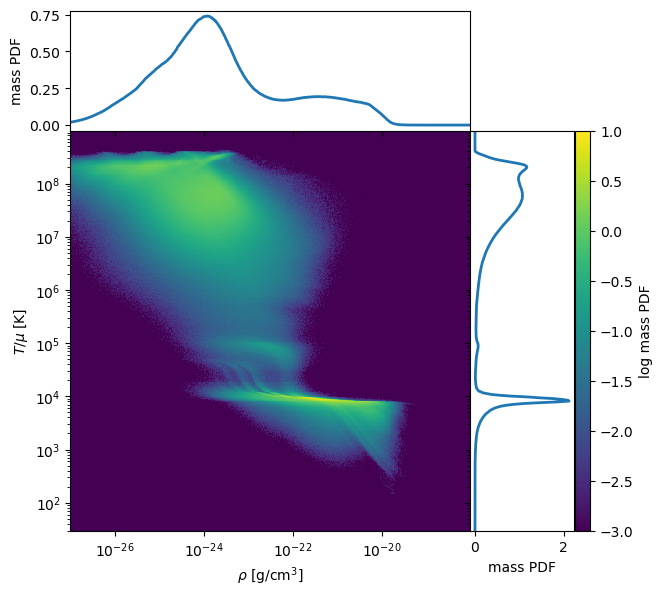

In [86]:
sim_dir = move_to_sim_dir(9, "mstar0p2")
data = SimpleNamespace(**np.load('starcat/data.npz'))

fig = plt.figure(figsize=(4, 4))
ax1 = fig.add_axes([0, 0, 1, 1])
im = ax1.pcolormesh(data.density2d_death, data.temp2d_death, np.log10(data.densitytemp_pdf2d_death + epsilon), vmin=-3, vmax=1.0)
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_ylim(30)

ax2 = fig.add_axes([0, 1, 1, 0.3], sharex=ax1)
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.plot(data.density1d_death, data.density_pdf1d_death, lw=2)

ax3 = fig.add_axes([1, 0, 0.3, 1], sharey=ax1)
plt.setp(ax3.get_yticklabels(), visible=False)
ax3.plot(data.temp_pdf1d_death, data.temp1d_death, lw=2)

add_cbar_to_ax(im, ax=ax3, size='15%', pad=0.01, label='log mass PDF')
ax1.set_xlabel(r'$\rho$ [${\rm g/cm^3}$]')
ax1.set_ylabel(r'$T / \mu$ [${\rm K}$]')
ax2.set_ylabel('mass PDF')
ax3.set_xlabel('mass PDF')


Moving to directory '/home/za9132/scratch/romain/round9/mstar0p2cut0p01'.


<a list of 3 text.Text objects>

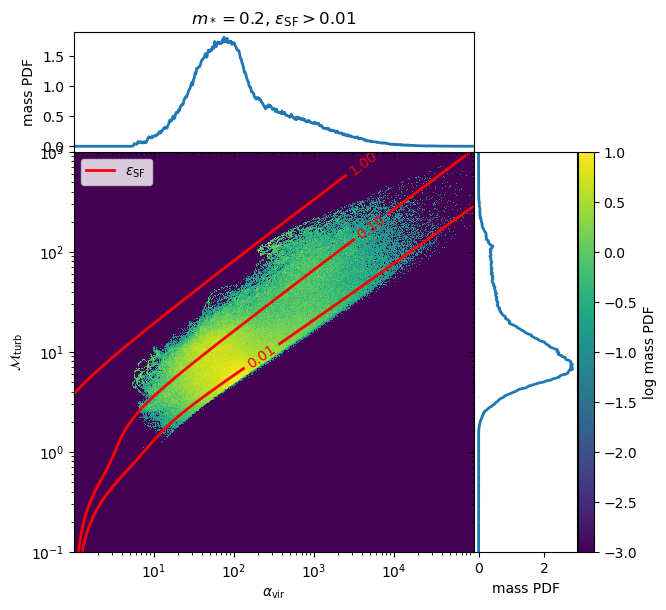

In [69]:
sim_round = 9
sim_name = "mstar0p2cut0p01"
sim_dir = move_to_sim_dir(sim_round, sim_name)
data = SimpleNamespace(**np.load('starcat/data.npz'))

fig = plt.figure(figsize=(4, 4))
ax1 = fig.add_axes([0, 0, 1, 1])
im = ax1.pcolormesh(data.alpha_vir2d, data.mach_turb2d, np.log10(data.alpha_virmach_turb_pdf2d + epsilon), vmin=-3, vmax=1)
ax1.set_xscale('log')
ax1.set_yscale('log')

ax2 = fig.add_axes([0, 1, 1, 0.3], sharex=ax1)
plt.setp(ax2.get_xticklabels(), visible=False)
ax2.plot(data.alpha_vir1d, data.alpha_vir_pdf1d, lw=2)

ax3 = fig.add_axes([1, 0, 0.3, 1], sharey=ax1)
plt.setp(ax3.get_yticklabels(), visible=False)
ax3.plot(data.mach_turb_pdf1d, data.mach_turb1d, lw=2)

add_cbar_to_ax(im, ax=ax3, size='15%', pad=0.01, label='log mass PDF')
ax1.set_xlabel(r'$\alpha_{\rm vir}$')
ax1.set_ylabel(r'$\mathcal{M}_{\rm turb}$')
ax2.set_ylabel('mass PDF')
ax3.set_xlabel('mass PDF')
ax1.set_ylim(1e-1, 1e3)
ax2.set_title(sim_name_to_latex[sim_name])

add_custleg_to_ax([r'$\varepsilon_{\rm SF}$'], ['red'], ax=ax1, loc=2)
alpha_vir2d, mach_turb2d = np.meshgrid(data.alpha_vir2d, data.mach_turb2d)
eps_sf = calc_eps_sf(alpha_vir2d, mach_turb2d, b_turb=1.0, eps_sf_loc=1.0)
cs = ax1.contour(alpha_vir2d, mach_turb2d, eps_sf, levels=[1e-2, 1e-1, 1e0], colors='red', linewidths=2)
plt.clabel(cs, [1e-2, 1e-1, 1e0])

#save_fig('phaseplot_alpha_cut')
